In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm
from decoders import naiveBayes
import itertools
import h5py

import config


In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'


# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()


/Users/frederictheunissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [5]:
# Number of Units without Whines
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 97):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



NameError: name 'dfDataBaseNW' is not defined

In [6]:
# Number of Units with Whines
unitNames = np.unique(dfDataBase['site']+'_'+ dfDataBase['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBase['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBase['stim'][dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)

191


In [7]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
# Use the following data if NW
#inPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'

inPath = rootPath+dataPath+'HerminaDataBase1UnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping  Use 13 if NW 12 otherwise.
indGood = np.argwhere(pcc > 12).flatten()
nGood = indGood.shape[0]

In [8]:
pccGood = pcc[indGood]
unitNamesGood = [unitNamesFull[i] for i in indGood]

indSort = np.flip(np.argsort(pccGood))

# Printing the name of the most discriminating units
birdName = []
for ind in indSort:
    print(unitNamesGood[ind], pccGood[ind])
    birdName.append(unitNamesGood[ind][0:4])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl 26.360434326725603
ZF7F_7t_190806_115742_goodPlayback-e13-c0.pkl 19.43376352108709
ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl 19.3922611150445
ZF4F_2t_190612_134337_goodPlayback-e16-c98.pkl 18.669185016155314
ZF4F_5t_190615_114154_goodPlayback-e20-c56.pkl 18.180298735672
ZF7F_5t_190720_152938_goodPlayback-e19-c65.pkl 17.986097749648305
ZF4F_2t_190613_101015.old_goodPlayback-e11-c62.pkl 17.741038436633367
ZF4F_7t_190619_095313_goodPlayback-e19-c49.pkl 17.316159758960968
ZF4F_6t_190616_142033_goodPlayback-e19-c38.pkl 17.230253782733975
ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl 17.05126138896764
ZF4F_3t_190613_150928_goodPlayback-e17-c97.pkl 16.907595803020097
ZF7F_7t_190806_115742_goodPlayback-e10-c65.pkl 16.82358990700664
ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl 16.576001372930396
ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl 16.180409934563144
ZF4F_2t_190612_134337_goodPlayback-e11-c27.pkl 16.03076077468061
ZF4F_2t_19061

In [18]:
# Decoding for a variable number of units.  
# For 1 and 2 and when combinations are smaller that maximum number of tests, all permutations are done. 

# FIrst make the list of arguments so that the multiprocessing can be called out.
# We are doing 1,2,3,4,5,10,20

numUnits = 15
code = 'PC'
maxTest = 9999
mpflag = True
nBirds = len(birdUnique)
argListBirds = [[] for i in range(nBirds)]
ntests = np.zeros((nBirds,), dtype=int)

for ibird, bird in enumerate(birdUnique):
    nGoodBird = len([x for x in birdName if x == bird])
    
    if nGoodBird < numUnits:
        continue
        
    ntests[ibird] = int(comb(nGoodBird,numUnits))
    if ntests[ibird] > maxTest:
        ntests[ibird] = maxTest + 1
    
    # Generate the good index for this bird
    indGoodBird = [ind for ind in indGood if unitNamesFull[ind][0:4] == bird]

    # Generate the list of arguments to run naiveBayes in parallel
    argList = argListBirds[ibird]
    if numUnits == 1:
        for i, ind in enumerate(indGoodBird):
            if i == ntests[ibird]:
                break
            unitChoice = [unitNamesFull[ind]]
            argList.append(unitChoice)
    elif numUnits == 2:  
        i = 0
        for i1, ind1 in enumerate(indGoodBird):
            if i1 == ntests[ibird]:
                break
            for i2, ind2 in enumerate(indGoodBird):
                if i2 <= i1:
                    continue
                if i2 == ntests[ibird]:
                    break
                unitChoice = [unitNamesFull[ind1], unitNamesFull[ind2]]
                argList.append(unitChoice)
                i += 1
    elif ntests[ibird] <= maxTest:
        # Generate all possible combinations
        unitNamesGood = np.array(unitNamesFull)[indGoodBird]
        for unitChoice in itertools.combinations(unitNamesGood, numUnits):
            argList.append(list(unitChoice))
    else:
        unitNamesGood = np.array(unitNamesFull)[indGoodBird]
        for i in range(ntests[ibird]):
            unitChoice = np.random.choice(unitNamesGood, numUnits, replace=False)
            argList.append(unitChoice)

In [23]:
# Run the decoders using multiprocessors if possible

# Run Naive Bayes in chunks of 90 with a pool of 30 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all or 90 and 1800 tests.
poolSize = 30

# Allocate memory for results
pccBirds = []
selHBirds = []
confMatTotBirds = []

for ibird, bird in enumerate(birdUnique):
    
    # Allocate bird specific storage for the results
    pcc = np.zeros((ntests[ibird],))
    selH = np.zeros((ntests[ibird],))
    confMatTot = np.zeros((ncalls, ncalls))
    confMatCount = 0
    
    # Calculate the number of chunks
    nchunks = ntests[ibird]//chunckSize
    if ntests[ibird] % chunckSize:
        nchunks += 1
        
    # Arglist for this bird
    argList = argListBirds[ibird]
    
    
    if mpflag == True:
        if __name__ == '__main__':
            for ichunk in range(nchunks):
                istart = ichunk*chunckSize
                iend = (ichunk+1)*chunckSize
                if iend > ntests[ibird]:
                    iend = ntests[ibird]         
        
                with mp.Pool(poolSize) as p:
                    results = p.map(naiveBayes, argList[istart:iend])
        
            # I don't think I need these??
            # p.close()
            # p.join()
        
                for i, res in enumerate(results):
                    confMat = res[1]
                    if (confMat.shape == (ncalls,ncalls) ):
                        pcc[istart + i] = res[0]
                        pccDiag = np.diag(confMat)
                        pccDiag = pccDiag/np.sum(pccDiag)
                        pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
                        selH[istart + i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
                        testsPerClass = res[2]
                        confMatTot = np.add(confMatTot, confMat)
                        confMatCount += testsPerClass
                
                print('Done with chunk %d/%d for bird %d/%d' % (ichunk+1, nchunks, ibird+1, nBirds))
    else:
        for i in range(ntests[ibird]):
            pccval, confMat, testsPerClass = naiveBayes(argList[i], code = code)
            pcc[i] = pccval
            pccDiag = np.diag(confMat)
            pccDiag = pccDiag/np.sum(pccDiag)
            pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
            selH[i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
            confMatTot = np.add(confMatTot, confMat)
            confMatCount += testsPerClass

    # Calculate the average confusion matrix. 
    for i in range(ncalls):
        if confMatCount[i] > 0:
            confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
            
    # Store the results in the bird lists
    pccBirds.append(pcc)
    selHBirds.append(selH)
    confMatTotBirds.append(confMatTot)
    
        
# save the PC and Confusion matrices data base
outPath = rootPath + dataPath + 'HerminaDataBase%dGoodUnitPCPerBird.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argListBirds, fileOut)
pk.dump(confMatTotBirds, fileOut)
pk.dump(pccBirds, fileOut)
pk.dump(selHBirds, fileOut)
pk.dump(birdUnique, fileOut)
fileOut.close()




Done with chunk 1/100 for bird 1/4
Done with chunk 2/100 for bird 1/4
Done with chunk 3/100 for bird 1/4
Done with chunk 4/100 for bird 1/4
Done with chunk 5/100 for bird 1/4
Done with chunk 6/100 for bird 1/4
Done with chunk 7/100 for bird 1/4
Done with chunk 8/100 for bird 1/4
Done with chunk 9/100 for bird 1/4
Done with chunk 10/100 for bird 1/4
Done with chunk 11/100 for bird 1/4
Done with chunk 12/100 for bird 1/4
Done with chunk 13/100 for bird 1/4
Done with chunk 14/100 for bird 1/4
Done with chunk 15/100 for bird 1/4
Done with chunk 16/100 for bird 1/4
Done with chunk 17/100 for bird 1/4
Done with chunk 18/100 for bird 1/4
Done with chunk 19/100 for bird 1/4
Done with chunk 20/100 for bird 1/4
Done with chunk 21/100 for bird 1/4
Done with chunk 22/100 for bird 1/4
Done with chunk 23/100 for bird 1/4
Done with chunk 24/100 for bird 1/4
Done with chunk 25/100 for bird 1/4
Done with chunk 26/100 for bird 1/4
Done with chunk 27/100 for bird 1/4
Done with chunk 28/100 for bird 1/4
D

Done with chunk 91/100 for bird 4/4
Done with chunk 92/100 for bird 4/4
Done with chunk 93/100 for bird 4/4
Done with chunk 94/100 for bird 4/4
Done with chunk 95/100 for bird 4/4
Done with chunk 96/100 for bird 4/4
Done with chunk 97/100 for bird 4/4
Done with chunk 98/100 for bird 4/4
Done with chunk 99/100 for bird 4/4
Done with chunk 100/100 for bird 4/4


In [24]:
for ibird in range(nBirds):
    print(np.mean(pccBirds[ibird]))

40.88488113434178
35.72121433293536
24.3743652347753
40.40394474902341


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


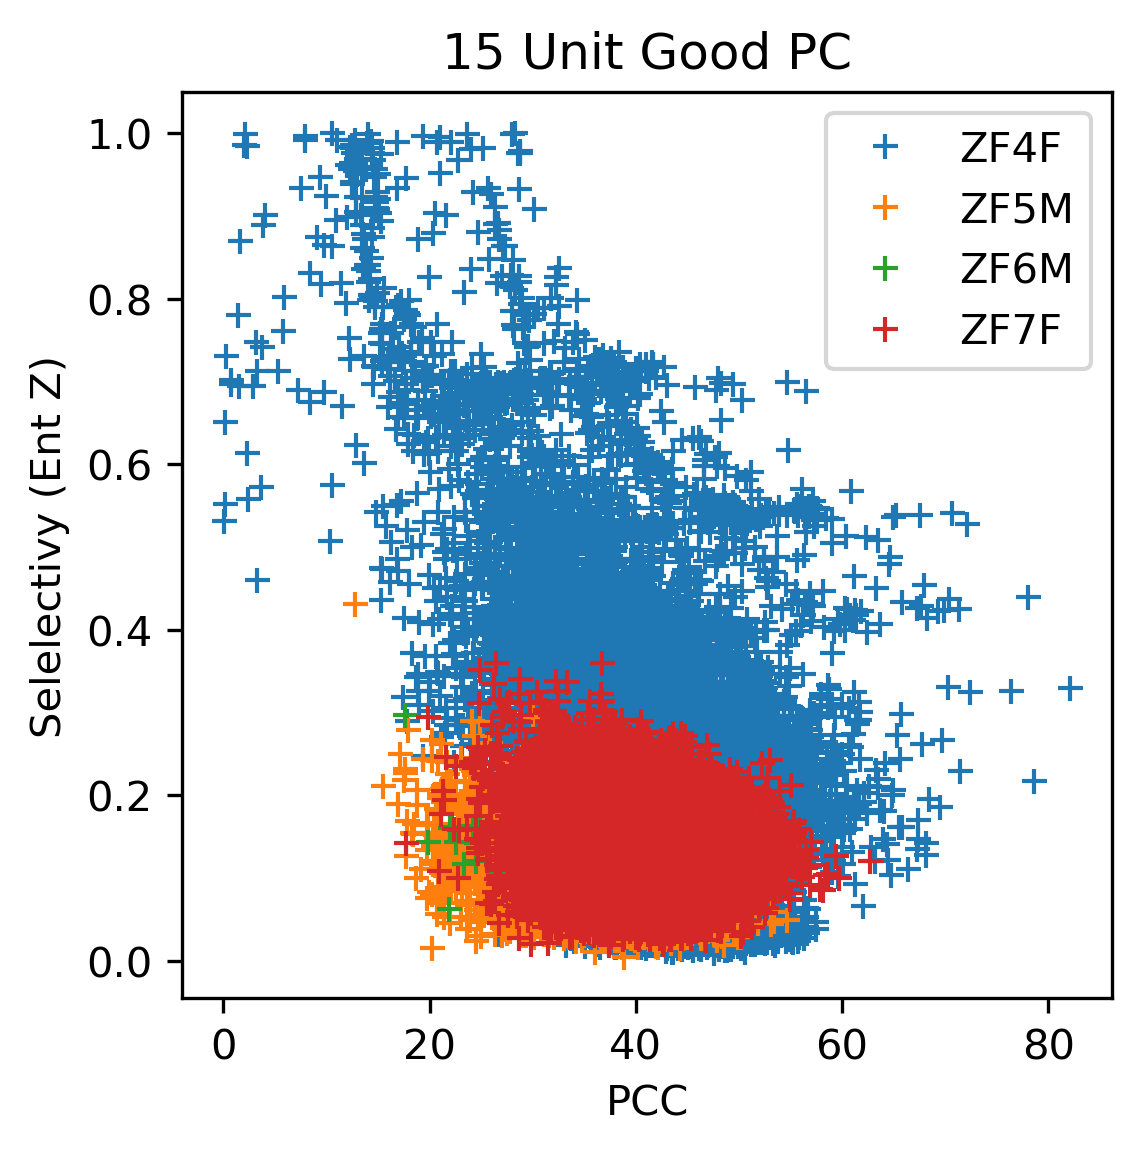

In [25]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for ibird, bird in enumerate(birdUnique):
    ax.plot(pccBirds[ibird], selHBirds[ibird], '+', label = bird)

ax.set_xlabel('PCC')
ax.set_ylabel('Selelectivy (Ent Z)')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/scatterPCCSelH%dUnitGoodPCPerBird.eps' % numUnits)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


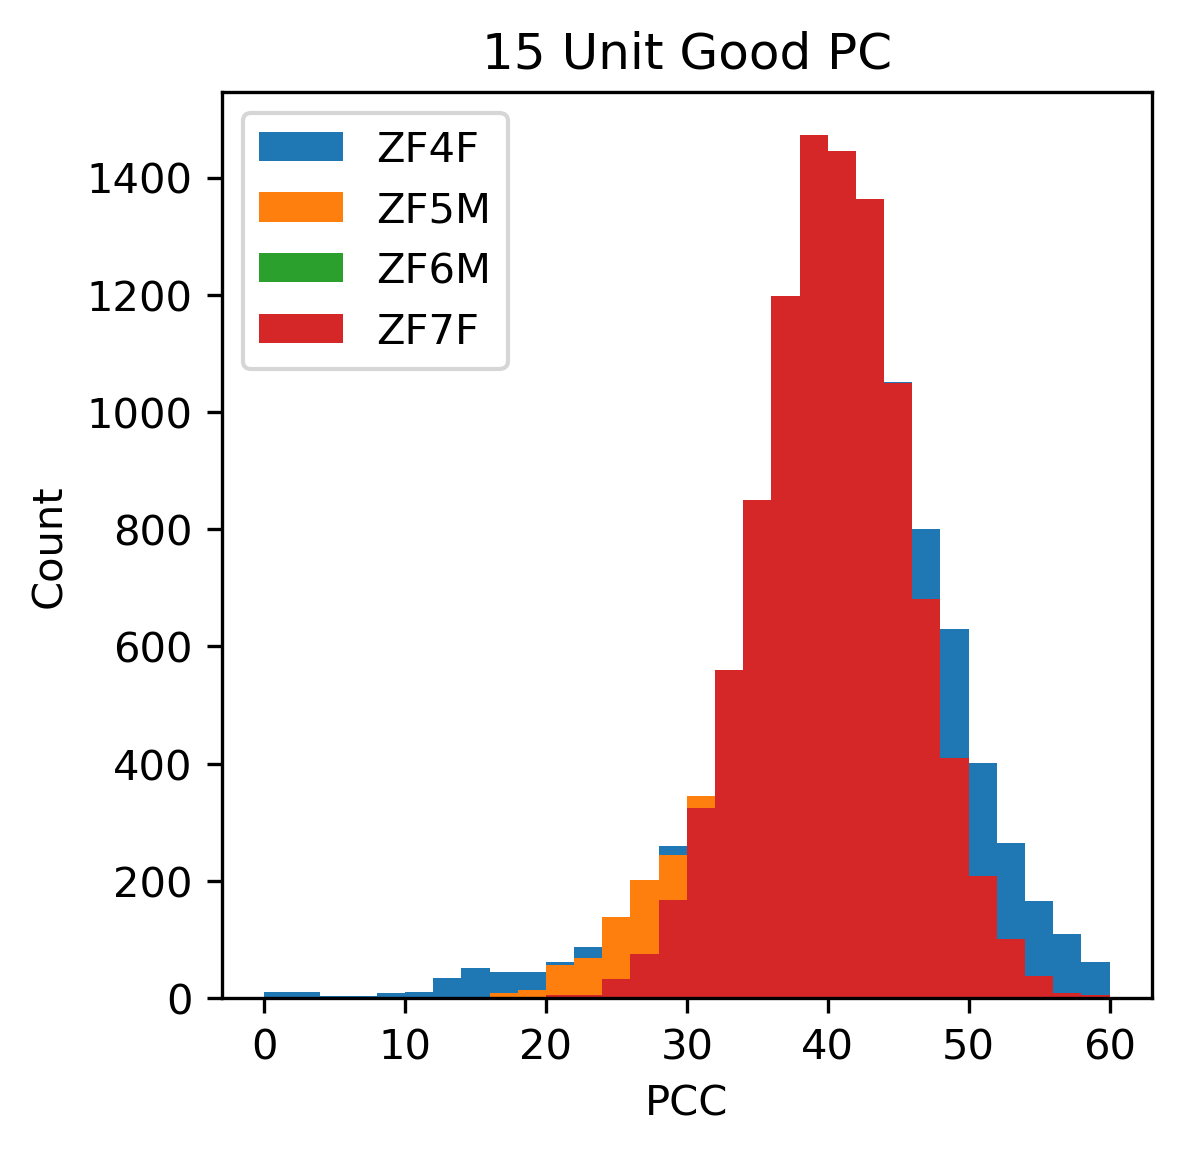

In [26]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for ibird, bird in enumerate(birdUnique):
   ax.hist(pccBirds[ibird], bins = 30, range = (0,60), label=bird)

ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodPCPerBird.eps' % numUnits)

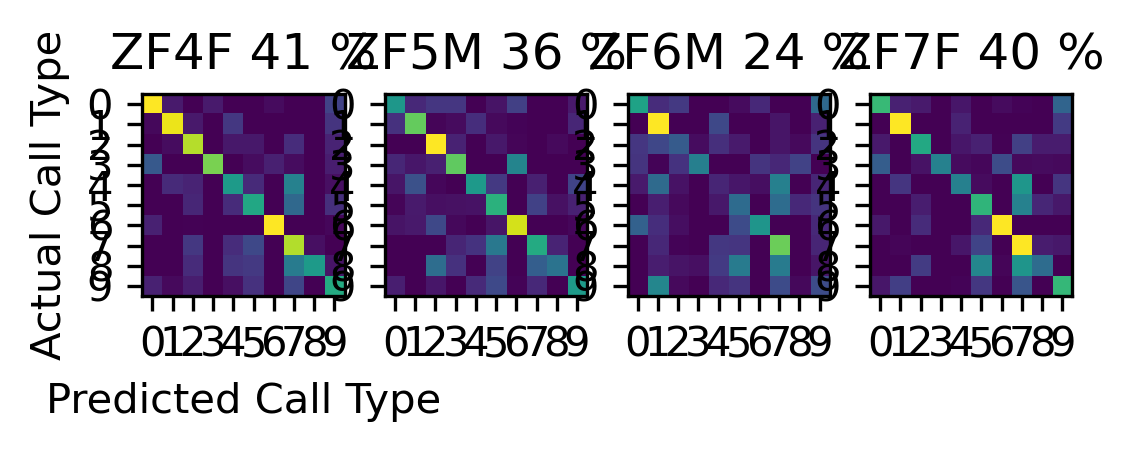

In [27]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,12), dpi=300)
axBirds = fig.subplots(1, nBirds)

for ibird, bird in enumerate(birdUnique):
    ax = axBirds[ibird]
    im_ = ax.imshow(confMatTotBirds[ibird]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 50)

    # if ibird == (nBirds-1) :
    #    fig.colorbar(im_, ax=ax)
    
    if ibird == 0 :
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%s %.0f %%' % (bird, np.mean(pccBirds[ibird])))
    else:
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%s %.0f %%' % (bird, np.mean(pccBirds[ibird])))
        

plt.savefig('/Users/frederictheunissen/Desktop/confMat%dUnitGoodPCPerBird.eps' % numUnits)
